## Model 5

This model uses residual blocks to see if the model can learn better than model 4.

In [75]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from DataLoader import DataGenerator 

In [76]:
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv3D, ReLU, LeakyReLU, BatchNormalization,\
                                    Add, Flatten, Dense, Conv3DTranspose
from tensorflow.keras.models import Model


def residual_block(x: Tensor, filters: int, kernel_size = (3, 3, 3)) -> Tensor:
    y = Conv3D(kernel_size=kernel_size, strides= 1, filters=filters, padding="same")(x)
    y = ReLU()(y)
    y = Conv3D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)
    return y

def encoder(x: Tensor):
    kernel_size = (3, 3, 3)
    C = 4
    num_res_blocks = 2
    num_comp_lay = 2
    
    x = Conv3D(kernel_size=kernel_size, strides=1, filters=C, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    first_skip_conn = x
    
    for j in range(num_res_blocks):
        skip_connection = x
        x = residual_block(x, filters=C)
        x = Add()([skip_connection, x])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C, padding="same")(x)
    x = Add()([first_skip_conn, x])
    
    C_mult = [2, 1]
    
    for i in range(num_comp_lay):
        C = int(x.get_shape()[-1])
        x = Conv3D(kernel_size=kernel_size, strides= 2, filters=C, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C_mult[i]*C, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)

        
    C = int(x.get_shape()[-1])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=int(C/2), padding="same")(x)

    return x

def decoder(x: Tensor):
    kernel_size = (3, 3, 3)
    num_res_blocks = 2
    nump_comp_lay = 2
    C = int(x.get_shape()[-1])
    
    x = Conv3D(kernel_size=kernel_size, strides=1, filters=2*C,padding="same")(x)
    
    C_div = [1, 2]
    
    for i in range(nump_comp_lay):
        C = int(x.get_shape()[-1])
        C_over_div = int(int(C)/C_div[i])
        x = Conv3D(kernel_size=kernel_size,strides= 1,filters=C_over_div, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv3DTranspose(C_over_div, kernel_size=kernel_size, strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)

    skip_connection = x
    
    C = 4

    for i in range(num_res_blocks):
        B_skip_connection = x
        x = residual_block(x, filters=C)
        x = Add()([B_skip_connection, x])
        
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C, padding="same")(x)
    x = Add()([skip_connection, x])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters= 1, padding="same")(x)

    return x

def Autoencoder():
    
    inputs = Input(shape=(12, 40, 40, 1))
    
    enc = encoder(inputs)
    dec = decoder(enc)
    
    model = Model(inputs, dec)

    model.compile(
        optimizer= keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
    )

    return model

In [77]:
model = Autoencoder() 
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 12, 40, 40,  0                                            
__________________________________________________________________________________________________
conv3d_60 (Conv3D)              (None, 12, 40, 40, 4 112         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_27 (LeakyReLU)      (None, 12, 40, 40, 4 0           conv3d_60[0][0]                  
__________________________________________________________________________________________________
conv3d_61 (Conv3D)              (None, 12, 40, 40, 4 436         leaky_re_lu_27[0][0]             
_______________________________________________________________________________________

In [78]:
#months = 10
#files = set('/lsdf/kit/scc/projects/abcde/1979/0'+str(i)+'/ERA5.pl.temperature.nc' for i in range(1,months))
z_train = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')

bs=10 # batch size (from paper above)
dic = OrderedDict({'t': 1})  # Choosing first pressure level from variable temperature.
chunk_time = 12

#Define train and test datasets.
dg_train = DataGenerator(z_train.sel(time=slice('1979'), longitude=slice(6,15.75), latitude=slice(55.5,45.75)), dic, chunk_time, batch_size=bs, load=True, shuffle=True) 

Loading data into RAM


In [79]:
history = model.fit(dg_train, validation_data = dg_train, epochs=100)

Epoch 1/100
73/73 [==============================] - 3s 36ms/step - loss: 0.9530 - val_loss: 0.8845
Epoch 2/100
73/73 [==============================] - 2s 30ms/step - loss: 0.7510 - val_loss: 0.6452
Epoch 3/100
73/73 [==============================] - 2s 30ms/step - loss: 0.6674 - val_loss: 0.6411
Epoch 4/100
73/73 [==============================] - 2s 30ms/step - loss: 0.6600 - val_loss: 0.6283
Epoch 5/100
73/73 [==============================] - 2s 30ms/step - loss: 0.6734 - val_loss: 0.6386
Epoch 6/100
73/73 [==============================] - 2s 30ms/step - loss: 0.5773 - val_loss: 0.5454
Epoch 7/100
73/73 [==============================] - 2s 30ms/step - loss: 0.6130 - val_loss: 0.6074
Epoch 8/100
73/73 [==============================] - 2s 30ms/step - loss: 0.6041 - val_loss: 0.5607
Epoch 9/100
73/73 [==============================] - 2s 30ms/step - loss: 0.5677 - val_loss: 0.5318
Epoch 10/100
73/73 [==============================] - 2s 30ms/step - loss: 0.5839 - val_loss: 0.5292

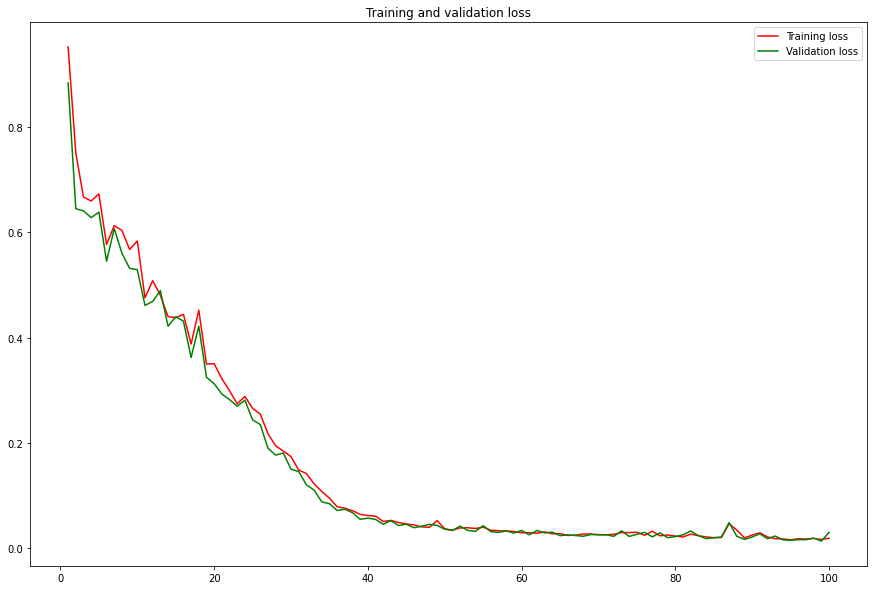

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

f = plt.figure(figsize=(15,10))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

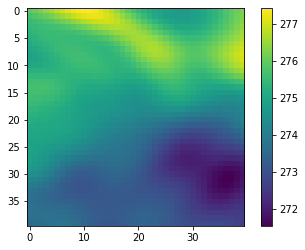

In [88]:
fig, ax = plt.subplots()
a = dg_train.__getitem__(8)[0] 
bb = plt.imshow(a[0,10,:,:,0]  * dg_train.std.values[0] + dg_train.mean.values[0],  cmap='viridis')
fig.colorbar(bb, orientation='vertical')
plt.show()

In [89]:
result = model(np.expand_dims(a[0], axis=0)).numpy()
result.shape

(1, 12, 40, 40, 1)

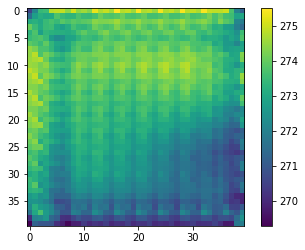

In [90]:
fig, ax = plt.subplots()
bb = plt.imshow((result[0,10,:,:,0] * dg_train.std.values[0] + dg_train.mean.values[0]))
fig.colorbar(bb, orientation='vertical')
plt.show()

In [91]:
test_data = z_train.sel(time=slice('1979-05-01T16:00:00','1979-05-02T03:00:00' ),level = slice(1),longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
# Normalize
mean = test_data['t'].mean(('time', 'latitude', 'longitude')).compute()
std = test_data['t'].std('time').mean(('latitude', 'longitude')).compute() 
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 12, 40, 40, 1)

## Results

Original:

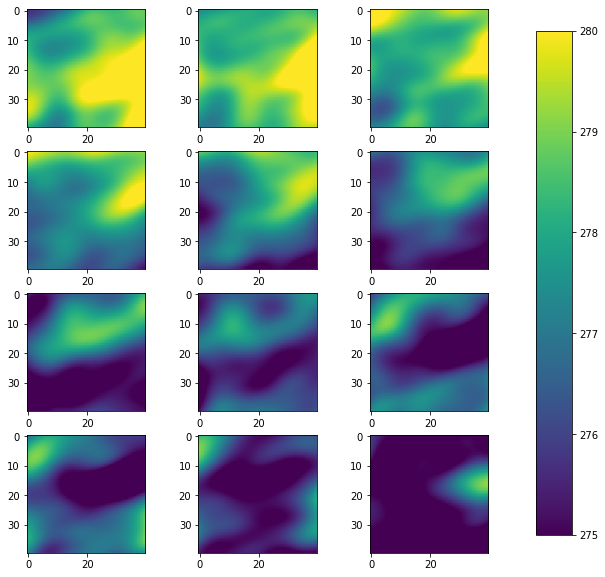

In [92]:
fig, ax = plt.subplots(4,3, figsize=(10,10))

count = 0
for i in range(4):
    for j in range(3):
        img = test_data[0,count,:,:,0] *std.values[0] + mean.values[0]
        im = ax[i, j].imshow(img,  vmin=275, vmax=280)
        count=count +1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im,  cax=cbar_ax)
plt.show()

Decompressed:

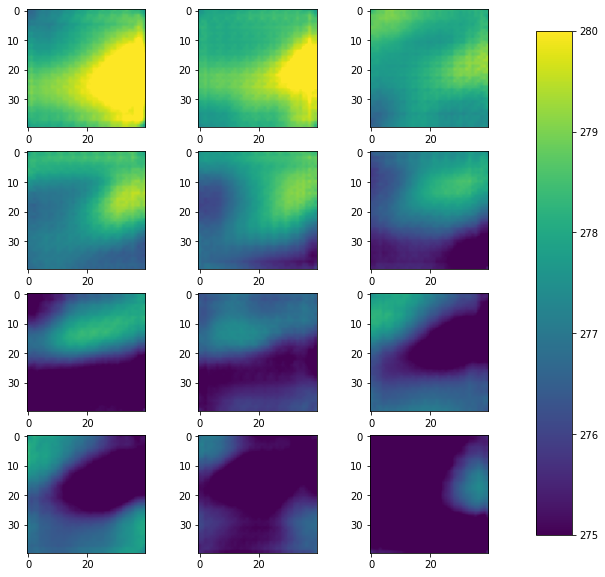

In [93]:
result2 = model(test_data).numpy()

fig, ax = plt.subplots(4,3, figsize=(10,10))

count = 0
for i in range(4):
    for j in range(3):
        img = result2[0,count,:,:,0] *std.values[0] + mean.values[0]
        im = ax[i, j].imshow(img,  vmin=275, vmax=280)
        count=count +1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im,  cax=cbar_ax)
plt.show()

The results are good!

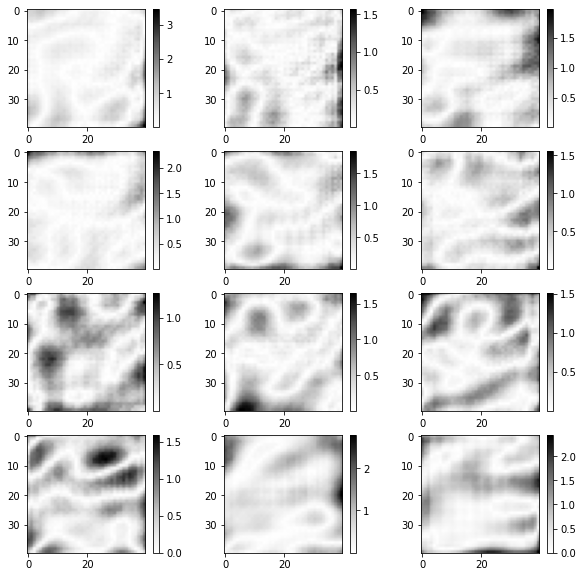

In [95]:
a = result2*std.values[0] + mean.values[0]
b = test_data*std.values[0] + mean.values[0]

result3 = np.absolute(a-b)

fig, ax = plt.subplots(4, 3, figsize=(10,10))
count = 0
for i in range(4):
    for j in range(3):
        img = result3[0,count,:,:,0] 
        im = ax[i, j].imshow(img, cmap = 'Greys')
        plt.colorbar(im, ax=ax[i, j])
        count = count +1

plt.show()